In [11]:
import numpy as np
x = np.load(
    r"C:\Users\AndreaEnrique\Documents\TFM_MBID_VIU\res\time_data_1_sec_force_quality_plus_t\x_for_ltsm.npy")
y = np.load(
    r"C:\Users\AndreaEnrique\Documents\TFM_MBID_VIU\res\time_data_1_sec_force_quality_plus_t\y_for_ltsm.npy")

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
SEED = 42

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

signal_x_train = x_train[:, :-1]
signal_x_test = x_test[:, :-1]
temp_x_train = x_train[:, -1].reshape(-1, 1)
temp_x_test = x_test[:, -1].reshape(-1, 1)

sc_temp = StandardScaler()
temp_x_train = sc_temp.fit_transform(temp_x_train)
temp_x_test = sc_temp.transform(temp_x_test)

sc = StandardScaler()
train_shape = signal_x_train.shape

signal_x_train = signal_x_train.reshape(train_shape[0]*train_shape[1])
signal_x_train = sc.fit_transform(signal_x_train.reshape(-1, 1))
signal_x_train = signal_x_train.reshape(train_shape[0], train_shape[1])

test_shape = signal_x_test.shape
signal_x_test = signal_x_test.reshape(test_shape[0]*test_shape[1])
signal_x_test = sc.transform(signal_x_test.reshape(-1, 1))
signal_x_test = signal_x_test.reshape(test_shape[0], test_shape[1])

In [13]:
import tensorflow as tf
from tensorflow import keras


time_input = keras.layers.Input(shape=(1666, 1))
temp_input = keras.layers.Input(shape=(1,))

conv_1 = keras.layers.Conv1D(filters=16, kernel_size=32, strides=2, activation='relu')(time_input)
maxpool_1 = keras.layers.MaxPooling1D(pool_size=8)(conv_1)

conv_2 = keras.layers.Conv1D(filters=32, kernel_size=16, strides=2, activation='relu')(maxpool_1)
maxpool_2 = keras.layers.MaxPooling1D(pool_size=8)(conv_2)

conv_3 = keras.layers.Conv1D(filters=64, kernel_size=2, strides=1, activation='relu')(maxpool_2)

flat = keras.layers.Flatten()(conv_3)

dense0 = keras.layers.Dense(1, activation="relu")(temp_input)

merged = keras.layers.Concatenate(axis=1)([flat, dense0])

dense_1 = keras.layers.Dense(128, activation='relu')(merged)
dense_2 = keras.layers.Dense(64, activation='relu')(dense_1)
output = keras.layers.Dense(13, activation='softmax')(dense_2)

model = keras.models.Model(inputs=[time_input, temp_input], outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1666, 1)]    0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 818, 16)      528         ['input_3[0][0]']                
                                                                                                  
 max_pooling1d_2 (MaxPooling1D)  (None, 102, 16)     0           ['conv1d_3[0][0]']               
                                                                                                  
 conv1d_4 (Conv1D)              (None, 44, 32)       8224        ['max_pooling1d_2[0][0]']        
                                                                                            

In [14]:
learning_rate = 0.0001
optimizer = keras.optimizers.Adam(
    learning_rate=learning_rate,
)
# Compile the model.
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc")
    ],
)

In [15]:
batch_size = 128
num_epochs = 500

# Create an early stopping callback.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1)

# Fit the model.
history = model.fit(
    x=[signal_x_train, temp_x_train],
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=2,
)

Epoch 1/500
1193/1193 - 7s - loss: 1.6453 - acc: 0.4329 - val_loss: 1.1866 - val_acc: 0.5532 - lr: 1.0000e-04 - 7s/epoch - 6ms/step
Epoch 2/500
1193/1193 - 6s - loss: 1.0692 - acc: 0.5985 - val_loss: 0.9742 - val_acc: 0.6324 - lr: 1.0000e-04 - 6s/epoch - 5ms/step
Epoch 3/500
1193/1193 - 6s - loss: 0.9154 - acc: 0.6545 - val_loss: 0.8588 - val_acc: 0.6734 - lr: 1.0000e-04 - 6s/epoch - 5ms/step
Epoch 4/500
1193/1193 - 6s - loss: 0.8112 - acc: 0.6888 - val_loss: 0.7771 - val_acc: 0.7003 - lr: 1.0000e-04 - 6s/epoch - 5ms/step
Epoch 5/500
1193/1193 - 6s - loss: 0.7432 - acc: 0.7129 - val_loss: 0.7184 - val_acc: 0.7247 - lr: 1.0000e-04 - 6s/epoch - 5ms/step
Epoch 6/500
1193/1193 - 6s - loss: 0.7010 - acc: 0.7286 - val_loss: 0.6826 - val_acc: 0.7378 - lr: 1.0000e-04 - 6s/epoch - 5ms/step
Epoch 7/500
1193/1193 - 6s - loss: 0.6728 - acc: 0.7388 - val_loss: 0.6620 - val_acc: 0.7443 - lr: 1.0000e-04 - 6s/epoch - 5ms/step
Epoch 8/500
1193/1193 - 6s - loss: 0.6481 - acc: 0.7476 - val_loss: 0.6529 -

In [16]:
_, accuracy = model.evaluate([signal_x_test, temp_x_test], y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

1491/1491 [==============================] - 4s 2ms/step - loss: 0.2258 - acc: 0.9170
Test accuracy: 91.7%


Test accuracy: 91.7%


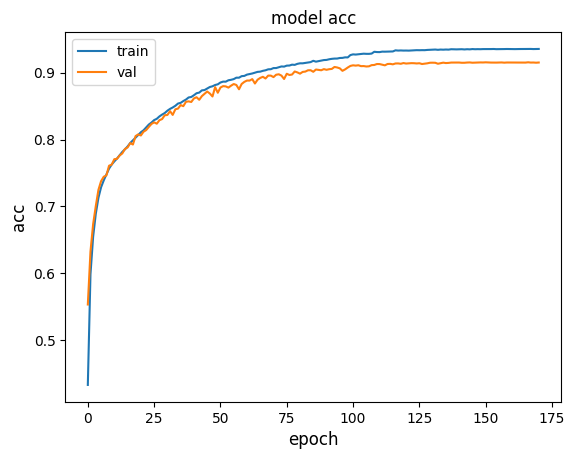

In [17]:
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
import matplotlib.pyplot as plt
metric = "acc"
plt.figure()
plt.plot(history.history[metric], label="train")
plt.plot(history.history["val_" + metric], label="val")
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend()
plt.show()
plt.close()

1491/1491 [==============================] - 3s 2ms/step


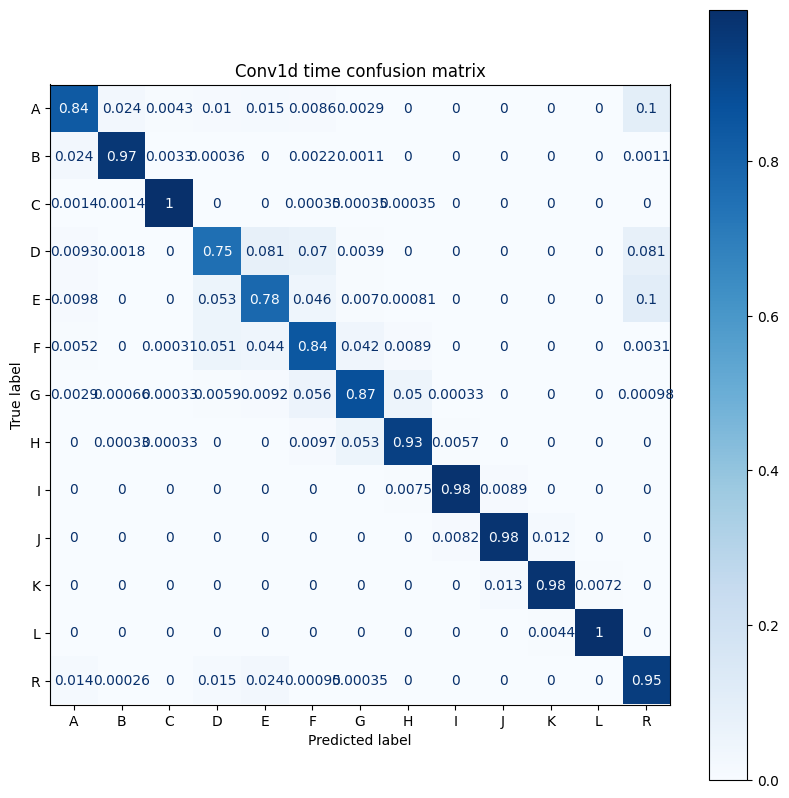

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))
y_pred = model.predict([signal_x_test, temp_x_test])
y_pred = np.argmax(y_pred, axis = 1)
np.set_printoptions(precision=2)
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=lb.inverse_transform(range(0, 13)),
    cmap=plt.cm.Blues,
    normalize="true",
    ax=ax
)
disp.ax_.set_title("Conv1d time confusion matrix")

plt.show()

In [19]:
model.save(r'C:\Users\AndreaEnrique\Documents\TFM_MBID_VIU\models\time_all_std_force_quality\Conv1D_time.h5', save_format="h5")